In [17]:
import numpy as np
import networkx as nx
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import pairwise_distances
# from sklearn.neighbors import NearestNeighbors
import embed_utils
from sklearn.model_selection import train_test_split
from copy import deepcopy
from collections import Counter
from matplotlib import pyplot as plt

In [18]:
def show_graph(G):
    # G = nx.Graph()
    # G.add_edge(1,2)
    # G.add_edge(2,3)
    # for v in G.nodes():
    #     G.node[v]['state']='X'
    # G.node[1]['state']='Y'
    # G.node[2]['state']='Y'

    # for n in G.edges_iter():
    #     G.edge[n[0]][n[1]]['state']='X'
    # G.edge[2][3]['state']='Y'

    node_labels = nx.get_node_attributes(G,embed_utils.CLASS_NAME)
    node_attr = nx.get_node_attributes(G,embed_utils.SENSATTR)

    color_map = []
    for node in G:
        if node_attr[node] == 0:
            color_map.append('blue')
        else: 
            color_map.append('green')   

    # pos = nx.spring_layout(G)

    # nx.draw(G, pos)
    nx.draw(G, node_color=color_map, labels = node_labels)
    # nx.draw_networkx_labels(G, pos, labels = node_labels)
    # edge_labels = nx.get_edge_attributes(G,'state')
    # nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
    # plt.savefig('this.png')
    plt.show()
    return

In [19]:
def get_metrics(classifier, test_nodes, embeddings, label_dict):
    test_node_embeddings = embeddings[test_nodes]
    test_node_labels = [label_dict[node] for node in test_nodes]
    pred = classifier.predict(test_node_embeddings)
    accuracy = sum(test_node_labels == pred) / len(test_node_labels)
    
    return accuracy


def check_classification_params(nodes, labels, embeddings):
    assert nodes == list(range(len(nodes)))
    assert len(labels) == len(nodes) == len(embeddings), f"{len(labels)}, {len(nodes)}, {len(embeddings)}"


def make_classification_model(nodes, labels, embeddings):
    """
    Makes the classification model
    :param nodes: should be the nodes as list of consecutive integers
    :param labels: should be a list of labels where a value of -1
        indicates a missing label
    :param embeddings: is the embeddings of all nodes obtained using a
        (modified) random walk

    :returns: a model with a predict() function that predicts the label
        from embeddings
    """
    check_classification_params(nodes, labels, embeddings)

    g = np.mean(pairwise_distances(embeddings))
    # TODO is this the right kernel?
    clf = LabelPropagation(kernel="knn", gamma = g).fit(embeddings, labels)

    return clf


def run_classification(graph, embeddings, name_ds=""):
    # show_graph(graph)

    # print("Graph info")
    # print(f"Number of nodes: {len(graph.nodes())}")
    # print(f"Number of edges: {len(graph.edges())}")
    # print(f"Length label dict: {len(nx.get_node_attributes(graph, embed_utils.CLASS_NAME))}")
    # print(f"Length attri dict: {len(nx.get_node_attributes(graph, embed_utils.SENSATTR))}")
    # print("Label dict:", nx.get_node_attributes(graph, embed_utils.CLASS_NAME))
    # print("Attri dict:", nx.get_node_attributes(graph, embed_utils.SENSATTR))

    # Get labels and attributes of test nodes to other classes
    label_dict = deepcopy(nx.get_node_attributes(graph, embed_utils.CLASS_NAME))
    attr_dict = deepcopy(nx.get_node_attributes(graph, embed_utils.SENSATTR))
    
    # Split in to equal sized train and test nodes
    nodes = list(graph.nodes())
    train_nodes, test_nodes = train_test_split(nodes, test_size=0.5, shuffle=True)
    train_nodes = set(train_nodes)

    # Get semi-supervised labels
    n_unique_labels = len(set(label_dict.values()))
    unique_labels = (x for x in np.arange(n_unique_labels+1, len(train_nodes) + n_unique_labels + 2))
    semi_supervised_y = [label_dict[node] if node in train_nodes else next(unique_labels) for node in nodes]

    # Train the classifier
    clf = make_classification_model(nodes, semi_supervised_y, embeddings)

    # test_node_embeddings = [emb for i, emb in enumerate(embeddings) if i in test_nodes]
    # test_node_labels = [label_dict[node] for node in test_nodes]
    # pred = classifier.predict(test_node_embeddings)
    # accuracy = sum(test_node_labels == pred) / len(test_node_labels)

    # Get test node embeddings, labels and find accuracy on test nodes
    c0_nodes = [node for node in test_nodes if attr_dict[node] == 0]
    acc_c0 = get_metrics(clf, c0_nodes, embeddings, label_dict) * 100

    c1_nodes = [node for node in test_nodes if attr_dict[node] == 1]
    acc_c1 = get_metrics(clf, c1_nodes, embeddings, label_dict) * 100

    accuracy = get_metrics(clf, test_nodes, embeddings, label_dict) * 100
    disparity = np.var([acc_c0, acc_c1])
    # print(f"Accuracy c0: {acc_c0}")
    # print(f"Accuracy c1: {acc_c1}")
    # print(f"Disparity: {disparity}") 
    # print()

    # print(f"Total accuracy: {accuracy}")
    # print()
    # print(f"Counter training lables: {Counter([label_dict[node] for node in train_nodes]).most_common(3)}")
    # print(f"Counter real lables: {Counter([label_dict[node] for node in test_nodes]).most_common(3)}")
    # print(
    #     f"Counter prediction: {Counter(clf.predict([emb for i, emb in enumerate(embeddings) if i in test_nodes])).most_common(3)}"
    #     )
    # print()

    return accuracy, disparity


n_runs = 200
experiment_settings = [
    ['rice', 'default', 'deepwalk'],
    ['rice', 'fairwalk', 'deepwalk'],
    ["rice", "crosswalk", "deepwalk"],
]
acc_list = []
disp_list = []
for dataset, reweight_method, embed_method in experiment_settings:
    # get graph from data
    graph = embed_utils.data2graph(dataset)

    # get embedding from graph
    embed = embed_utils.graph2embed(
                                        graph, 
                                        reweight_method, 
                                        embed_method
                                        )

    accs = []
    disparities = []
    for i in range(n_runs):
        acc, disparity = run_classification(graph, embed)
        accs.append(acc)
        disparities.append(disparity)
    acc_list.append(accs)
    disp_list.append(disparities)

Node 138 has no neighbors.
Node 160 has no neighbors.
Node 245 has no neighbors.
Node 272 has no neighbors.
Node 355 has no neighbors.
Node 428 has no neighbors.


In [20]:
np.mean(accs), np.mean(disparities)

(25.876681614349774, 13.98602578771945)

In [21]:
np.var(accs), np.var(disparities)

(5.859352691588409, 322.56694861000756)

In [22]:
names = [reweight_method for  _, reweight_method, _ in experiment_settings]
for name, accs, disps in zip(names, acc_list, disp_list):
    print(f'Reweighting method: {name}')
    print(f"Accuracy: {np.mean(accs)}")
    print(f'Acc')
    print(f"Disparity: {np.mean(disps)}")
    print()

Reweighting method: default
Accuracy: 79.11434977578477
Acc
Disparity: 225.30104739094847

Reweighting method: fairwalk
Accuracy: 75.64349775784754
Acc
Disparity: 75.03084857414066

Reweighting method: crosswalk
Accuracy: 25.876681614349774
Acc
Disparity: 13.98602578771945



In [23]:
print(np.mean(acc_list))
print(np.mean(disp_list))

60.21150971599402
104.77264058426954


In [24]:
acc_means = [np.mean(accs) for accs in acc_list]
print(acc_means)
acc_minmax = [[np.min(accs), np.max(accs)] for accs in acc_list]
print(acc_minmax)

[79.11434977578477, 75.64349775784754, 25.876681614349774]
[[72.6457399103139, 86.54708520179372], [67.71300448430493, 82.95964125560538], [17.040358744394617, 31.838565022421523]]


In [25]:
disp_means = [np.mean(disps) for disps in disp_list]
print(disp_means)
disp_minmax = [[np.min(disps), np.max(disps)] for disps in disp_list]
print(disp_minmax)

[225.30104739094847, 75.03084857414066, 13.98602578771945]
[[38.16574761385071, 454.79661858604914], [0.004876564401860327, 237.42091004353261], [0.0020736493906787397, 87.71203442833777]]


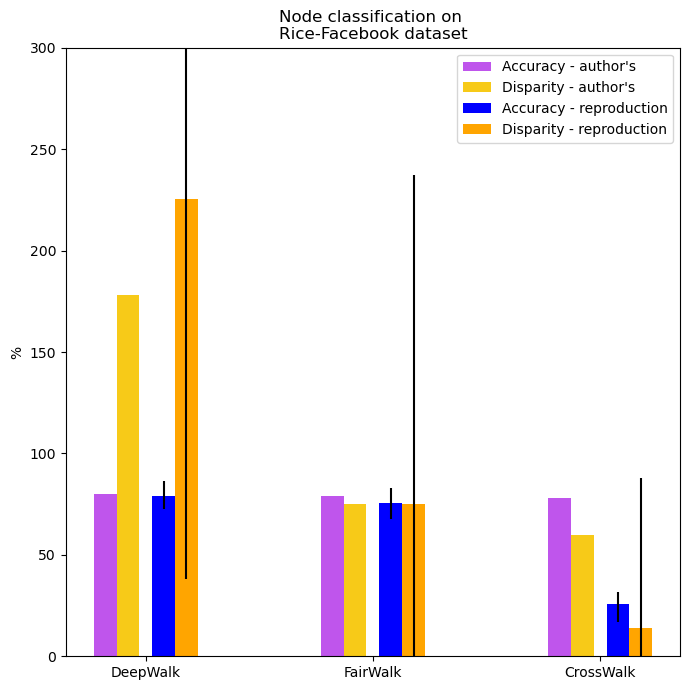

In [34]:
import matplotlib.pyplot as plt
import numpy as np

purple_ = '#BF55EC'
yellow_ = '#F7CA18'

labels = ['DeepWalk', 'FairWalk', 'CrossWalk']
# accuracy_means_our = [79.24439461883408, 74.33632286995517, 30.132286995515695]
# accuracy_min_max = np.array([[72.19730941704036, 84.30493273542601], [66.81614349775785, 79.82062780269058], [22.869955156950674, 36.771300448430495]])
acc_err_our = np.array([(mean-min, max-mean) for mean, (min, max) in zip(acc_means, acc_minmax)]).T

# disparity_means_our = [205.2821218107538, 119.0225343476247, 17.542225623210268]
# disparity_min_max = np.array([[47.149340227244736, 531.0282388874407], [0.1505356222488088, 415.8686224489794], [0.00014172335600909044, 84.62145181619547]])
disp_err_our = np.array([(mean-min, max-mean) for mean, (min, max) in zip(disp_means, disp_minmax)]).T

accuracy_means_auth = [80, 79, 78]
disparity_means_auth = [178, 75, 60]

x = np.array([2, 5.5, 9]) # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 7))
bars1 = ax.bar(x - width*1.5 -0.1, accuracy_means_auth, width, label='Accuracy - author\'s', color=purple_)
bars2 = ax.bar(x - width/2 -0.1, disparity_means_auth, width, label='Disparity - author\'s', color=yellow_)
bars3 = ax.bar(x + width/2 +0.1, acc_means, width, label='Accuracy - reproduction', color="blue", yerr=acc_err_our)
bars4 = ax.bar(x + width*1.5 +0.1, disp_means, width, label='Disparity - reproduction', color="orange", yerr=disp_err_our)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('Node classification on \nRice-Facebook dataset')
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(bars1, padding=3)
# ax.bar_label(bars2, padding=3)
#
# ax.bar_label(bars3, padding=3)
# ax.bar_label(bars4, padding=3)

ax.set_ylim(top=300)
fig.tight_layout()

plt.show()